In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sns

import eq

import sys
from pathlib import Path
import os
project_root_path = Path(os.path.dirname(eq.__file__)).parent 
sys.path.append(str(project_root_path/"experiments"/"train_mle"))

results_dir = Path(eq.__file__).parents[1] / "results"

font = {'size'   : 8}
mpl.rc('font',**font)
mpl.rcParams['axes.labelsize'] = 8 

ETAS_color = 'tab:red' 
ETAS_lw = 1
NTPP_color = 'k'
real_color = 'grey'

# Trimmed catalogs
We compare the relative performance of ETAS and the NTPP on incrementally larger dataset.

## Load benchmark results on synthetic data
We first benchark and test the approach for this comparison on synthetic ETAS-generated data. The expectation on this dataset is that the NTPP performance should converge but not exceed the ETAS perfomance. In this case, we use ```ETAS_SingleCatalog_trimmed.csv```, a single very long catalog for divided incrementatlly longer testing and validation periods and a fixed-lenght testing period. Results are shown below:

In [9]:
results = pd.read_csv(results_dir / "ETAS_SingleCatalog_trimmed.csv", index_col=0)
results.head()

,model_name,random_seed,num_events_train,nll_test,loglike_test
0,RecurrentTPP,4.0,679,0.120311,-0.120311
1,RecurrentTPP,3.0,679,0.121113,-0.121113
2,RecurrentTPP,2.0,679,0.119591,-0.119591
3,RecurrentTPP,1.0,679,0.121739,-0.121739
4,RecurrentTPP,0.0,679,0.119934,-0.119934


## Plot benchmark results

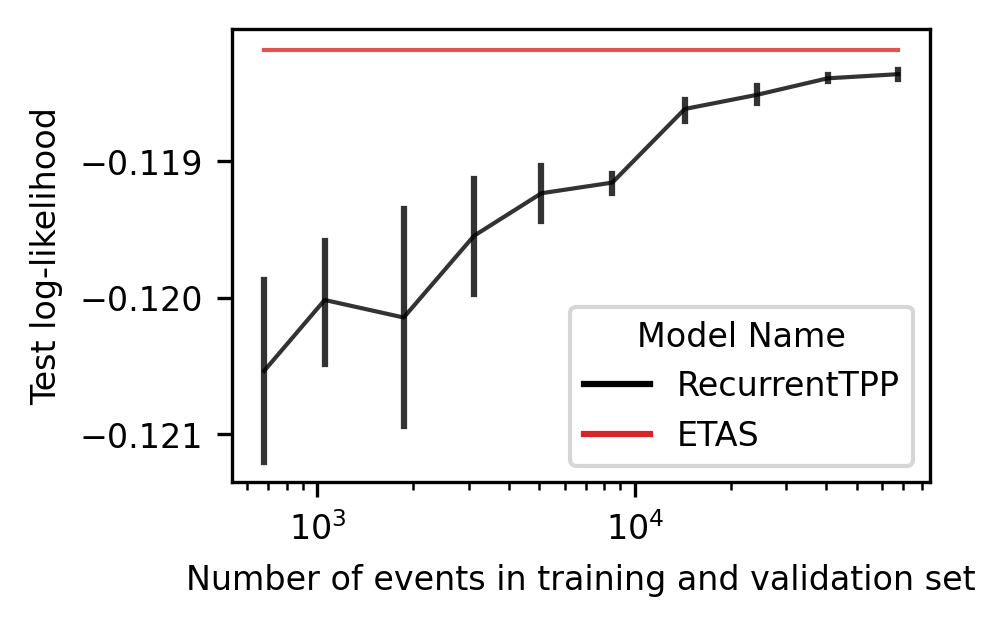

In [10]:
fig, ax = plt.subplots(dpi=300,figsize=(3,2))
sns.lineplot(
    data=results, 
    x="num_events_train", 
    y="loglike_test",
    palette=[NTPP_color,ETAS_color],
    hue="model_name",
    err_style="bars",
    markers=['o','o'],
    lw=1,
    alpha=0.8,
    ax=ax)
ax.set_xscale('log')
ax.set_xlabel('Number of events in training and validation set')
ax.set_ylabel("Test log-likelihood")
lg = ax.get_legend()
lg.set_title("Model Name")

**Fig S2: Inversion results on a single long synthetic ETAS-derived data**. Running the same experimental procedure as featured below, we obtain a consistently better model on the part of the ETAS model. 

## Load results
We next consider the real-world earthquake catalog from 2008 to 2021 (12) bounding the San Jacinto fault ```eq.catalogs.White```. This catalog makes a good test case because of its dense station-coverage of a particularly seismically active area. We again place the models head to head, training them on the 2008 to 2014 interval, using 2014 to 2017 for validation, and reserving 2017 to 2020 as the test set. The NTPP outperforms ETAS in terms of goodness-of-fit in the reserved test period (Fig. 3B, S2). Incrementally extending the training set backward in time improves the relative performance of the NTPP. ETAS is the preferred model when trained on fewer than 10,000 events; extending beyond ~10,000 events, the NTPP model outperforms ETAS.


In [11]:
results = pd.read_csv(results_dir / "White_trimmed.csv", index_col=0)
results.head()

,model_name,random_seed,num_events_train,nll_test,loglike_test
0,RecurrentTPP,4.0,778,-87.514565,87.514565
1,RecurrentTPP,3.0,778,-88.068275,88.068275
2,RecurrentTPP,1.0,778,-88.058365,88.058365
3,RecurrentTPP,0.0,778,-88.111526,88.111526
4,RecurrentTPP,2.0,778,-87.887756,87.887756


In [12]:
cat = eq.catalogs.White(
    project_root_path/"data"/"White",
)
catalog_size_array =  results.loc[results["model_name"] == "ETAS"]["num_events_train"].to_numpy()

Loading existing catalog from /nfs/homedirs/shchur/research/earthquake-ntpp-release/data/White.


In [13]:
# Convert days in the sequence into actual dates
def day2timestamp(N,start_time_stamp=cat.metadata["start_ts"]):
    return start_time_stamp + N * pd.Timedelta(1,'D')


def plt_cat(ax,cat):

    p = lambda t,m,c='darkslategrey',label=None: ax.scatter(t,m,s=np.exp(m/5),alpha=0.1,c=c, label=label,edgecolors='none')
    pc= lambda t, c='k', label=None: axb.plot(t,np.arange(len(t)),       c=c, label=label)
    
    seq = cat.full_sequence
    t = day2timestamp(seq.arrival_times.numpy())
    m = seq.mag.numpy()
    
    ax.axvspan(cat.metadata['test_start_ts'], cat.metadata['end_ts'],color='r',    alpha=0.1)
    # ax.axvspan(cat.metadata['test_start_ts'], cat.metadata['end_ts'],edgecolor='r',facecolor = None)
    
    p(t,m)
    ax.margins(x=0)
    ax.set_ylim((np.min(m),None))
    ax.margins(y=0)
    
    t_train         = t[t<cat.metadata['val_start_ts']]
    t_val           = t[(t>=cat.metadata['val_start_ts']) & (t<cat.metadata['test_start_ts'])]
    t_test          = t[t>cat.metadata['test_start_ts']]
    incs            = np.logspace(-2,0,len(catalog_size_array))
    n_train = len(t_train)
    n_val   = len(t_val)
    for i,inc in enumerate(incs):
        l1 = int(n_train*inc)
        l2 = int(n_val*inc)
        y = ax.get_ylim()[0] + (i*(ax.get_ylim()[1]-ax.get_ylim()[0])/len(catalog_size_array))/3
        ax.plot([t_train[-l1+1],t_val[l2-1]],[y,y],c='white',lw=1)
    offset = 8000 # events
    [ax.annotate(s,(ti[offset],(ax.get_ylim()[1]-ax.get_ylim()[0])*0.01+ax.get_ylim()[0]),ha='left',va='bottom',color='white') 
     for s,ti in zip(['Training','Val.','Test'],[t_train,t_val,t_test])]
    [ax.axvline(cat.metadata[t_string],color='k',ls='--',lw=1) for t_string in ['val_start_ts','test_start_ts']]
    ax.set_ylabel(r'$(M_L)$')
    # axb.set_ylabel('# of events')
    plt.yticks(rotation = 90, va='center')

    # ax.annotate('Training', (0.01,0.01), color='white', xycoords='axes fraction', 
    #             horizontalalignment='left', verticalalignment='bottom')
    #ax.yaxis.set_label_coords(-.04, .9)
    
    for label in ax.xaxis.get_ticklabels()[::2]:
        label.set_visible(False)

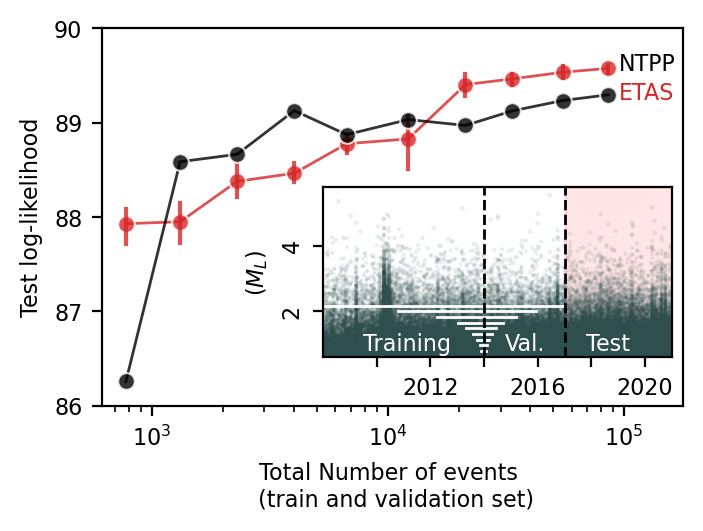

In [14]:
fig,ax = plt.subplots(figsize=(3.75,2.5),dpi=200)


sns.lineplot(
    data=results, 
    x="num_events_train", 
    y="loglike_test", 
    hue="model_name",
    palette=[ETAS_color,NTPP_color],
    style="model_name",
    err_style="bars",
    markers=['o','o'],
    dashes=False,
    legend=False,
    lw=1,
    alpha=0.8,
    ax=ax,
)

ax.set_ylabel('Test log-likelihood')
ax.set_xlabel('Total Number of events \n (train and validation set)')

ax.annotate('ETAS',(0.89,0.8),color=ETAS_color, xycoords='axes fraction', 
                horizontalalignment='left', verticalalignment='bottom')
ax.annotate('NTPP',(0.89,0.875),color=NTPP_color, xycoords='axes fraction', 
                horizontalalignment='left', verticalalignment='bottom')

ax.set_xscale("log")
ax.set_xlim((None,10**5.25))
ax.set_ylim((86.0,90))
ax.set_yticks(ax.get_yticks()[::2])

# Create inset of width 30% and height 40% of the parent axes' bounding box
# at the lower left corner (loc=3)
axins = inset_axes(
    ax, width="60%", height="45%", loc=4, 
    bbox_to_anchor=(0,0.1,1,1), bbox_transform=ax.transAxes)
plt_cat(axins,cat)

**Fig. 3. Increased performance on modern earthquake catalogs (A-B)**.  (A) Seismicity around the San Jacinto Fault zone in Southern California (White et al., 2019). (B) Model relative goodness of fit on the out-of-sample test period as measured by the joint log-likelihood for the NTPP and ETAS model. Error bars indicate 95% confidence interval of 1000 bootstrap samples for five random initializations of the NTPP model. Both models were trained on incrementally longer training and validation sets (shown with white bars in the inset). Given a training catalog in excess of ~10,000 earthquakes, the test period is best modeled by the NTPP model. 
